<a href="https://colab.research.google.com/github/stephenkiilu/Kernel-Methods-data-challenge/blob/main/Data_Challenge_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

## Loading data
***

In [128]:
X = np.loadtxt('Xtr.csv', skiprows=1, usecols=(1,), dtype=str, delimiter=',')
y = np.loadtxt('Ytr.csv', skiprows=1, usecols=(1,), dtype=int, delimiter=',')
X_test = np.loadtxt('Xte.csv', skiprows=1, usecols=(1,), dtype=str, delimiter=',')
X_tr_vectors = np.loadtxt('Xtr_vectors.csv', skiprows=1, usecols=(1,), dtype=str, delimiter=',')
X_te_vectors = np.loadtxt('Xte_vectors.csv', skiprows=1, usecols=(1,), dtype=str, delimiter=',')

# X_full = np.hstack([X, X_test])
y = 2*y - 1.


## My data
---

In [129]:
x_test=(np.loadtxt('Xte_vectors.csv', skiprows=1, dtype=str, delimiter=',')[:,1:]).astype(float)# whole data in vectors
x_train=(np.loadtxt('Xtr_vectors.csv', skiprows=1, dtype=str, delimiter=',')[:,1:]).astype(float)
y # train set-labels
print(x_test.shape)
print(x_train.shape)
print(y.shape)

(1000, 64)
(2000, 64)
(2000,)


## Split the data

In [130]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_train, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1500, 64)
(500, 64)
(1500,)
(500,)


## PCA plot

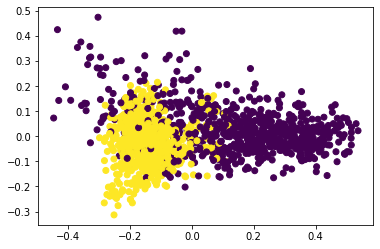

In [131]:
## training set
pca = PCA(n_components=2)
components = pca.fit_transform(X_train)
plt.scatter(components[:,0],components[:,1],c=y_train)

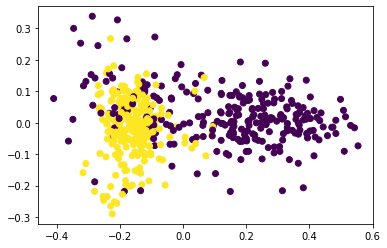

In [132]:
## test set
pca = PCA(n_components=2)
components_test = pca.fit_transform(X_test)
plt.scatter(components_test[:,0],components_test[:,1],c=y_test)

## sklearn models (for comparison purposes and sanity checks)

In [133]:
from sklearn.model_selection import train_test_split
import sklearn
from sklearn import linear_model as lm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

In [134]:
c1=10
c2=10
c3=10

## logistic
clf=LogisticRegression(random_state=0,C=c1)
clf.fit(X_train,y_train)
pred=clf.predict(X_test)
acc_log=accuracy_score(y_test, pred)
##SVM-linear

clf1 = LinearSVC(penalty='l2', loss='hinge', C=c1)
clf1.fit(X_train,y_train)
pred1=clf1.predict(X_test)
acc_svc=accuracy_score(y_test, pred1)

clf3=SVC(C=10)
clf3.fit(X_train,y_train)
pred2=clf3.predict(X_test)
acc_K_svc=accuracy_score(y_test, pred2)

print(acc_log)
print(acc_svc)
print(acc_K_svc)

0.956
0.958
0.966


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


## Saving my predictions

In [135]:
prediction=np.where(pred2==1,1,0)
y_save = np.vstack([1 + np.arange(len(prediction)), prediction]).T
np.savetxt('sample_prediction.csv', y_save,
           delimiter=',', header='Id,Covid', fmt='%i', comments='')

## Implementing our own code

## 1.Ridge logistic regression

## Logistic Ridge Regression with Gradient Descent

In [136]:
# Logistic Ridge Regression (LRR) with gradient descent (GD)
def solveLRR_gradient(y, X, lam, h=0.01, max_iter=500, eps=1e-12):
    '''
    lam: Regularization parameter
    max_iter: Max number of iterations of gradient descent
    eps: Tolerance for stopping criteria 
    '''
    n, p = X.shape
    assert (len(y) == n)
    
    beta_old = np.zeros(p)
    
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
            
    for i in range(max_iter):
        # yi beta^T xi
        f = (X * y[:, None]).dot(beta_old)
        gradient = - 1 / n * (y * sigmoid(-f)).dot(X)
        gradient += 2 * lam * beta_old
        
        # Step
        beta_new = beta_old - h * gradient
        
        if np.sum((beta_new-beta_old)**2) < eps:
            break
        beta_old = beta_new
    #         
    return (beta_new)

In [137]:
lam =0.00001
beta_gradient = solveLRR_gradient(y_train, X_train, lam, h=1, max_iter=10000)

In [138]:
def sigmoid(x):
        return 1 / (1 + np.exp(-x))
probas_pred = sigmoid(X_test.dot(beta_gradient))

y_pred = np.where(probas_pred > 0.5,1,-1) 

# print('Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred)))
def accuracy(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual))

In [139]:
print('The accuracy for logistic regression is: {:.2%}'.format(accuracy(y_test,y_pred)))

The accuracy for logistic regression is: 95.80%


##2. Kernel kernel SVM

## Utilities

In [140]:
import cvxopt

def cvxopt_qp(P, q, G, h, A, b):
    P = .5 * (P + P.T)
    cvx_matrices = [
        cvxopt.matrix(M) if M is not None else None for M in [P, q, G, h, A, b] 
    ]
    #cvxopt.solvers.options['show_progress'] = False
    solution = cvxopt.solvers.qp(*cvx_matrices, options={'show_progress': False})
    return np.array(solution['x']).flatten()

solve_qp = cvxopt_qp

***
Example kernel implementations
----
***

In [141]:
def rbf_kernel(X1, X2, sigma=10):
    '''
    Returns the kernel matrix K(X1_i, X2_j): size (n1, n2)
    where K is the RBF kernel with parameter sigma
    
    Input:
    ------
    X1: an (n1, p) matrix
    X2: an (n2, p) matrix
    sigma: float
    '''
    # For loop with rbf_kernel_element works but is slow in python
    # Use matrix operations!
    X2_norm = np.sum(X2 ** 2, axis = -1)
    X1_norm = np.sum(X1 ** 2, axis = -1)
    gamma = 1 / (2 * sigma ** 2)
    K = np.exp(- gamma * (X1_norm[:, None] + X2_norm[None, :] - 2 * np.dot(X1, X2.T)))
    return K

def sigma_from_median(X):
    '''
    Returns the median of ||Xi-Xj||
    
    Input
    -----
    X: (n, p) matrix
    '''
    pairwise_diff = X[:, :, None] - X[:, :, None].T
    pairwise_diff *= pairwise_diff
    euclidean_dist = np.sqrt(pairwise_diff.sum(axis=1))
    return np.median(euclidean_dist)

In [142]:
def linear_kernel(X1, X2):
    '''
    Returns the kernel matrix K(X1_i, X2_j): size (n1, n2)
    where K is the linear kernel
    
    Input:
    ------
    X1: an (n1, p) matrix
    X2: an (n2, p) matrix
    '''
    return X1@X2.T

def polynomial_kernel(X1, X2, degree=2):
    '''
    Returns the kernel matrix K(X1_i, X2_j): size (n1, n2)
    where K is the polynomial kernel of degree `degree`
    
    Input:
    ------
    X1: an (n1, p) matrix
    X2: an (n2, p) matrix
    '''
    return (1+linear_kernel(X1,X2))**2

In [143]:
# Prediction error
def error(ypred, ytrue):
    e = (ypred != ytrue).mean()
    return e

def add_column_ones(X):
    n = X.shape[0]
    return np.hstack([X, np.ones((n, 1))])

# Visualization
# References: https://scikit-learn.org/stable/auto_examples/svm/plot_iris.html
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(classifier, xx, yy, add_intercept=False, **params):
    """Plot the decision boundaries for a classifier.
    
    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    X = np.c_[xx.ravel(), yy.ravel()]
    Z = classifier.predict(X)#, fit_intercept=add_intercept)
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

def plot_decision_function(classifier, X_train, y_train, title='', add_intercept=False):
    fig = plt.figure(figsize=(8,7))
    X0, X1 = X_train[:, 0], X_train[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(classifier, xx, yy, cmap=plt.cm.GnBu, alpha=0.5, add_intercept=add_intercept)
    plt.scatter(X0, X1, c=y_train, cmap=plt.cm.GnBu, s=20, edgecolors='k')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.title(title)
    plt.show()

***
# Kernel Methods
***

In [144]:
class KernelMethodBase(object):
    '''
    Base class for kernel methods models
    
    Methods
    ----
    fit
    predict
    fit_K
    predict_K
    '''
    kernels_ = {
        'linear': linear_kernel,
        'polynomial': polynomial_kernel,
        'rbf': rbf_kernel,
        # 'mismatch': mismatch_kernel,
    }
    def __init__(self, kernel='linear', **kwargs):
        self.kernel_name = kernel
        self.kernel_function_ = self.kernels_[kernel]
        self.kernel_parameters = self.get_kernel_parameters(**kwargs)
        self.fit_intercept_ = False
        
    def get_kernel_parameters(self, **kwargs):
        params = {}
        if self.kernel_name == 'rbf':
            params['sigma'] = kwargs.get('sigma', 1.)
        if self.kernel_name == 'polynomial':
            params['degree'] = kwargs.get('degree', 2)
        return params

    def fit_K(self, K, y, **kwargs):
        pass
        
    def decision_function_K(self, K):
        pass
    
    def fit(self, X, y, fit_intercept=False, **kwargs):

        if fit_intercept:
            X = add_column_ones(X)
            self.fit_intercept_ = True
        self.X_train = X
        self.y_train = y

        K = self.kernel_function_(self.X_train, self.X_train, **self.kernel_parameters)

        return self.fit_K(K, y, **kwargs)
    
    def decision_function(self, X):

        if self.fit_intercept_:
            X = add_column_ones(X)

        K_x = self.kernel_function_(X, self.X_train, **self.kernel_parameters)

        return self.decision_function_K(K_x)

    def predict(self, X):
        pass
    
    def predict_K(self, K):
        pass

***
## Kernel SVM
***

In [145]:
def svm_dual_soft_to_qp_kernel(K, y, C=1):
    n = K.shape[0]
    assert (len(y) == n)
        
    # Dual formulation, soft margin
    P = P = np.diag(y)@K@np.diag(y)
    # As a regularization, we add epsilon * identity to P
    eps = 1e-12
    P += eps * np.eye(n)
    q = - np.ones(n)
    G = np.vstack([-np.eye(n), np.eye(n)])
    h = np.hstack([np.zeros(n), C * np.ones(n)])
    A = y[np.newaxis, :]
    b = np.array([0.])
    return P, q, G, h, A, b

K = linear_kernel(X_train, X_train)
alphas = solve_qp(*svm_dual_soft_to_qp_kernel(K, y_train, C=1.))

In [146]:
y_train.shape,y.shape,X_train.shape

((1500,), (2000,), (1500, 64))

In [147]:
class KernelSVM(KernelMethodBase):
    '''
    Kernel SVM Classification
    
    Methods
    ----
    fit
    predict
    '''
    def __init__(self, C=0.1, **kwargs):
        self.C = C
        super().__init__(**kwargs)
    
    def fit_K(self, K, y, tol=1e-3):
        # Solve dual problem
        self.alpha = solve_qp(*svm_dual_soft_to_qp_kernel(K, y, C=self.C))
        
        # Compute support vectors and bias b
        sv = np.logical_and((self.alpha > tol), (self.C - self.alpha > tol))
        self.bias = y[sv] - K[sv].dot(self.alpha * y)
        self.bias = self.bias.mean()

        self.support_vector_indices = np.nonzero(sv)[0]
        self.beta = self.alpha * y

        return self
        
    def decision_function_K(self, K_x):
        # print('K', K_x.shape, 'alpha', self.alpha.shape, 'bias', self.bias)
        return K_x@(self.alpha * self.beta) +self.bias
        # return K_x.dot(self.alpha * self.y_train) + self.bias

    def predict(self, X):
        # return np.sign(self.decision_function(X))
        return np.where(self.decision_function(X)>0.5,1,-1)

In [148]:
# candidates=np.arange(0.1,20,0.2)
# l={}
# for i in candidates:
#   kernel = 'linear'
#   sigma = 1.
#   degree = 2
#   C = i
#   tol = 1e-3
#   model = KernelSVM(C=C, kernel=kernel, sigma=sigma, degree=degree)
#   y_pred = model.fit(X_train, y_train, tol=tol).predict(X_test)
#   # print('Test error: {:.2%}'.format(error(y_pred, y_test)))
#   # print('Accuracy: {:.2%}'.format(accuracy_score(y_pred, y_test)))
#   l[i]=accuracy_score(y_pred, y_test)





In [149]:
kernel = 'linear'
sigma = 1
degree = 2
C = 9.1
tol = 1e-3
model = KernelSVM(C=C, kernel=kernel, sigma=sigma, degree=degree)
y_pred = model.fit(X_train, y_train, tol=tol).predict(X_test)
print('Test error: {:.2%}'.format(error(y_pred, y_test)))
print('Accuracy: {:.2%}'.format(accuracy_score(y_pred, y_test)))

Test error: 6.00%
Accuracy: 94.00%


In [150]:
kernel = 'linear'
sigma = 1
degree = 2
C = 1.5
tol = 1e-3
model = KernelSVM(C=C, kernel=kernel, sigma=sigma, degree=degree)
y_pred = model.fit(x_train, y, tol=tol).predict(x_test)
# print('Test error: {:.2%}'.format(error(y_pred, y_test)))
# print('Accuracy: {:.2%}'.format(accuracy_score(y_pred, y_test)))

In [151]:
prediction=np.where(y_pred==1,1,0)
y_save = np.vstack([1 + np.arange(len(prediction)), prediction]).T
np.savetxt('Yte.csv', y_save,
           delimiter=',', header='Id,Covid', fmt='%i', comments='')

In [152]:
# prediction